# Target thickness and type scan
K. Sjobak, October 23rd 2018, January 2019

The purpose of this script is to scan the target thicknesses for a few different materials, counting the types of particles coming out of the target.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import stats
import ROOT

Welcome to JupyROOT 6.28/06


In [2]:
# %matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 120
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
# }

In [4]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner

## Physics setup

In [5]:
### Parameters for radiation length calculation ###

# Element data from PDG
# http://pdg.lbl.gov/2018/AtomicNuclearProperties/index.html
A = {} #[g/mole]
Z = {} #[e]
dens = {} #[g/cm3]

# http://pdg.lbl.gov/2009/reviews/rpp2009-rev-atomic-nuclear-prop.pdf
radLen = {} #[g/cm^2]

A   ["Cu"] = 63.546
Z   ["Cu"] = 29
dens["Cu"] = 8.960 

A   ["Al"] = 26.9815385
Z   ["Al"] = 13
dens["Al"] = 2.699

A   ["W"] = 183.84
Z   ["W"] = 74
dens["W"] = 19.30 

A   ["U"] = 238.02891
Z   ["U"] = 92
dens["U"] = 18.95 

radLen["Sapphire"] = 27.94
dens["Sapphire"] = 4.0 #approximate

# radLen["StainlessSteel"] = 0.0
# dens["StainlessSteel"] = 8.0

A   ["Pb"] = 207.2
Z   ["Pb"] = 82
dens["Pb"] = 11.35

radLen["Water"] = 36.08
dens["Water"] = 1.0

def computeX0(elem):
    #Computes in the radiation length in g/cm^2
    if not elem in A:
        return radLen[elem]
    
    return (716.4 * A[elem]) / \
        ( Z[elem] * (Z[elem]+1) * np.log(287.0/np.sqrt(Z[elem])) )
def computeL(elem):
    #Computes the radiation length in mm
    return 10*computeX0(elem)/dens[elem]
def printRadLenData(elem):
    print(elem+":", computeX0(elem),"[g/cm^2] -> ", computeL(elem),"[mm]")

printRadLenData("Cu")
printRadLenData("Al")
printRadLenData("W")
printRadLenData("U")
printRadLenData("Sapphire")
printRadLenData("Pb")
printRadLenData("Water")


Cu: 13.161223577110464 [g/cm^2] ->  14.688865599453642 [mm]
Al: 24.26462615100901 [g/cm^2] ->  89.90228288628757 [mm]
W: 6.765675400738047 [g/cm^2] ->  3.5055312957191953 [mm]
U: 5.864297561258721 [g/cm^2] ->  3.094616127313309 [mm]
Sapphire: 27.94 [g/cm^2] ->  69.85000000000001 [mm]
Pb: 6.310506879854028 [g/cm^2] ->  5.559917955818527 [mm]
Water: 36.08 [g/cm^2] ->  360.79999999999995 [mm]


In [6]:
### Basic simulation parameters ###

NUM_THREADS = 16
QUIET = False
TRYLOAD = True #Try to load already existing data instead of recomputing?
TMPFOLDER = "/tmp/miniScatter/PLE_thicknessScan"

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
baseSimSetup["PHYS"] = "QGSP_BERT"
baseSimSetup["BEAM"] = "e-"
baseSimSetup["N"] = 100000

baseSimSetup["ENERGY"] = 200.0 #[MeV]
#EPS   = 3.0 #[um]
#BETA  = 1.4 #[m]
#ALPHA = 0.0
#baseSimSetup["COVAR"] = (EPS,BETA,ALPHA) #Use pencil beam

#baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["ZOFFSET"]           = 0.0 #Auto

baseSimSetup["DIST"] = 100.0 #Detector distance from target center [mm] 

baseSimSetup["QUICKMODE"] = True #Skip verification plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files

#Cutoffs for _cutoff analyses
baseSimSetup["CUTOFF_ENERGYFRACTION"] = 0.5
baseSimSetup["CUTOFF_RADIUS"] = 100.0 #[mm]


In [7]:
### Scan points in radiation lengths ###

#thickScan_radLen = np.logspace(-2,1,50)
thickScan_radLen = np.logspace(-3, 1.0, 64)
print("Radiation lengths:")
print(thickScan_radLen)

#baseSimSetup["ZOFFSET_BACKTRACK"]=True

#thickScan2_radLen = np.logspace(-2,1,20)
#print(thickScan2_radLen)


Radiation lengths:
[1.00000000e-03 1.15742288e-03 1.33962772e-03 1.55051578e-03
 1.79460244e-03 2.07711393e-03 2.40409918e-03 2.78255940e-03
 3.22059792e-03 3.72759372e-03 4.31440226e-03 4.99358789e-03
 5.77969288e-03 6.68954879e-03 7.74263683e-03 8.96150502e-03
 1.03722510e-02 1.20050806e-02 1.38949549e-02 1.60823388e-02
 1.86140669e-02 2.15443469e-02 2.49359200e-02 2.88614044e-02
 3.34048498e-02 3.86635375e-02 4.47500630e-02 5.17947468e-02
 5.99484250e-02 6.93856788e-02 8.03085722e-02 9.29509790e-02
 1.07583590e-01 1.24519708e-01 1.44121960e-01 1.66810054e-01
 1.93069773e-01 2.23463373e-01 2.58641621e-01 2.99357729e-01
 3.46483486e-01 4.01027914e-01 4.64158883e-01 5.37228112e-01
 6.21800109e-01 7.19685673e-01 8.32980665e-01 9.64110880e-01
 1.11588399e+00 1.29154967e+00 1.49486913e+00 1.73019574e+00
 2.00256814e+00 2.31781818e+00 2.68269580e+00 3.10501350e+00
 3.59381366e+00 4.15956216e+00 4.81437242e+00 5.57226480e+00
 6.44946677e+00 7.46476041e+00 8.63988449e+00 1.00000000e+01]


## Plotting macros

In [8]:
def showYield_singleSim(thickScan,numPart,N, cutoff=False, xZoom=None, singleParticle=None):
    plt.figure()
    if singleParticle == None:
        plt.subplot(1,2,1)
    if singleParticle == None or singleParticle == 'Positrons':
        plt.title("Positrons")
        plt.plot(thickScan,numPart["target"  if not cutoff else "target_cutoff"] [-11]/N, label="target")
        plt.plot(thickScan,numPart["tracker" if not cutoff else "tracker_cutoff"][-11]/N, label="tracker")
        plt.legend(loc='upper right')
        plt.xlabel('Target thickness [mm]')
        plt.ylabel('$N_{out}/N_{original}$')
        if xZoom:
            plt.xlim(xZoom[0],xZoom[1])

    if singleParticle == None:
        plt.subplot(1,2,2)
    if singleParticle == None or singleParticle == 'Electrons':
        plt.title("Surviving electrons")
        plt.plot(thickScan,numPart["target"  if not cutoff else "target_cutoff"] [11]/N, label="target")
        plt.plot(thickScan,numPart["tracker" if not cutoff else "tracker_cutoff"][11]/N, label="tracker")
        plt.legend(loc='upper right')
        plt.xlabel('Target thickness [mm]')
        if singleParticle != None:
            plt.ylabel('$N_{out}/N_{original}$')
        if xZoom:
            plt.xlim(xZoom[0],xZoom[1])

## Simulate scattering in various materials

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Cu.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


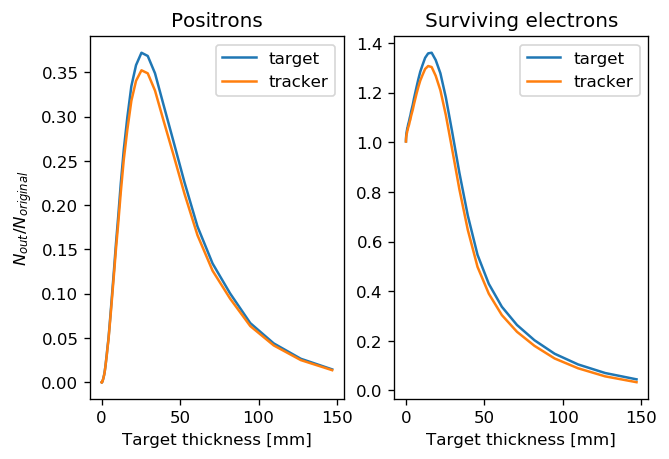

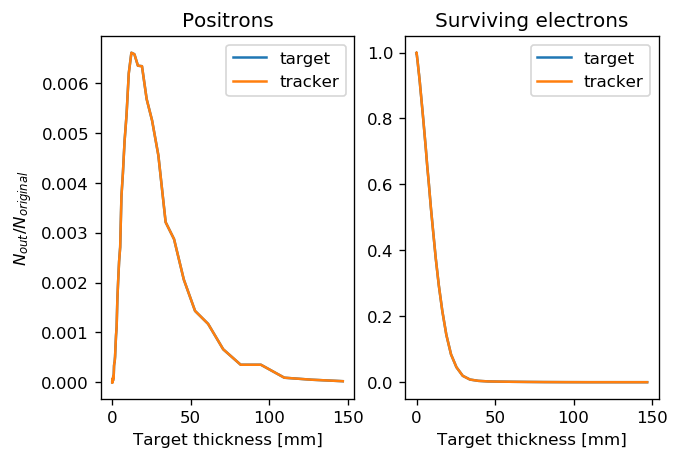

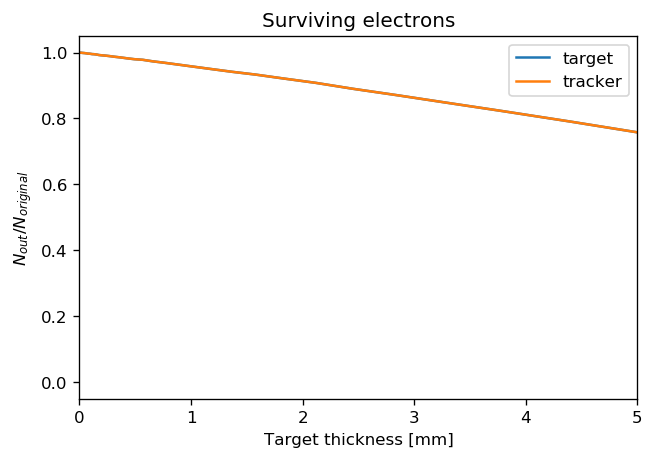

In [9]:
baseSimSetup_Cu = baseSimSetup.copy()
baseSimSetup_Cu["MAT"] = "G4_Cu"
thickScan_Cu = thickScan_radLen*computeL("Cu")

(twiss_Cu, numPart_Cu, objects_Cu, analysis_output_Cu) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Cu,baseSimSetup_Cu, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Cu", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_Cu,numPart_Cu,baseSimSetup_Cu["N"])
showYield_singleSim(thickScan_Cu,numPart_Cu,baseSimSetup_Cu["N"], cutoff=True)
showYield_singleSim(thickScan_Cu,numPart_Cu,baseSimSetup_Cu["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')

plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-W.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


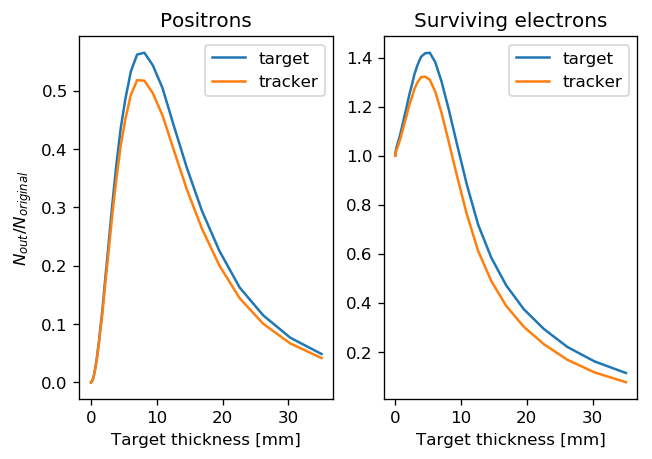

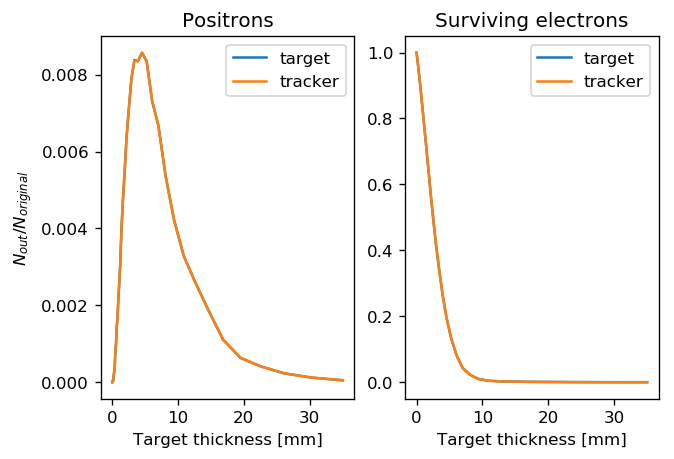

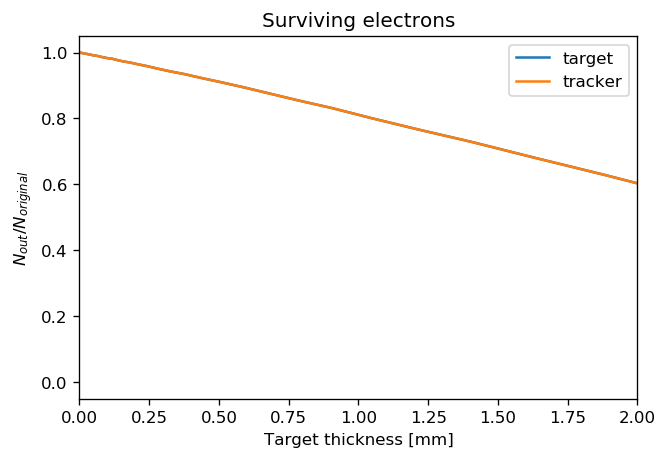

In [10]:
baseSimSetup_W = baseSimSetup.copy()
baseSimSetup_W["MAT"] = "G4_W"
thickScan_W = thickScan_radLen*computeL("W")

(twiss_W, numPart_W, objects_W, analysis_output_W) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_W,baseSimSetup_W, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-W", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_W,numPart_W,baseSimSetup_W["N"])
showYield_singleSim(thickScan_W,numPart_W,baseSimSetup_W["N"], cutoff=True)
showYield_singleSim(thickScan_W,numPart_W,baseSimSetup_W["N"], cutoff=True, xZoom=[0.0,2.0], singleParticle='Electrons')
plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-U.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


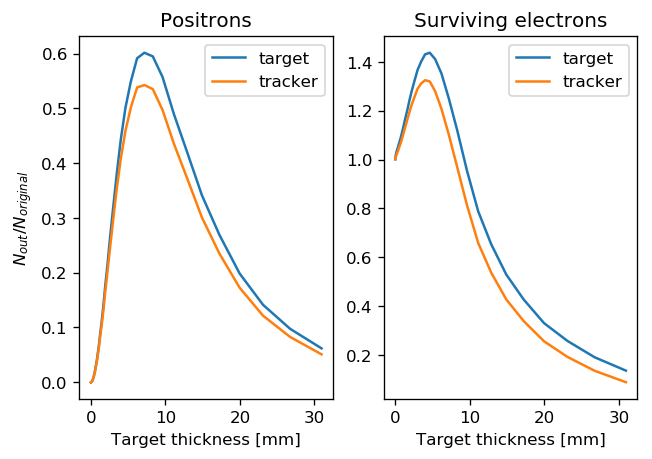

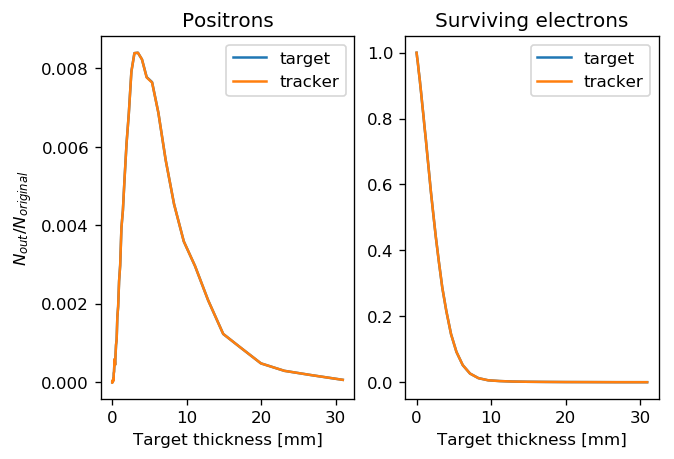

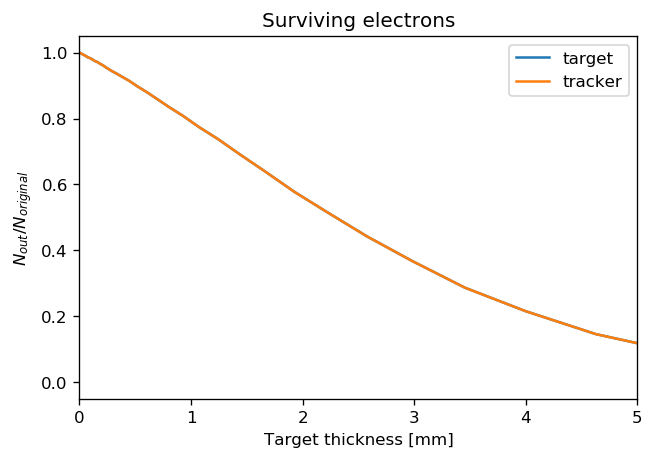

In [11]:
baseSimSetup_U = baseSimSetup.copy()
baseSimSetup_U["MAT"] = "G4_U"
thickScan_U = thickScan_radLen*computeL("U")

(twiss_U, numPart_U, objects_U, analysis_output_U) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_U,baseSimSetup_U, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-U", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_U,numPart_U,baseSimSetup_U["N"])
showYield_singleSim(thickScan_U,numPart_U,baseSimSetup_U["N"], cutoff=True)
showYield_singleSim(thickScan_U,numPart_U,baseSimSetup_U["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')
plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Al.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


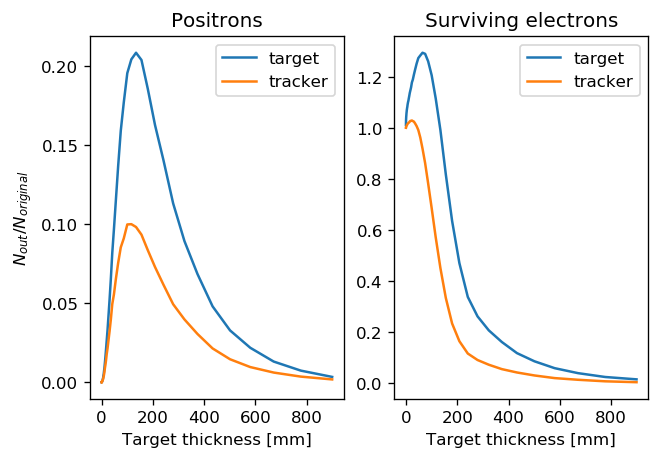

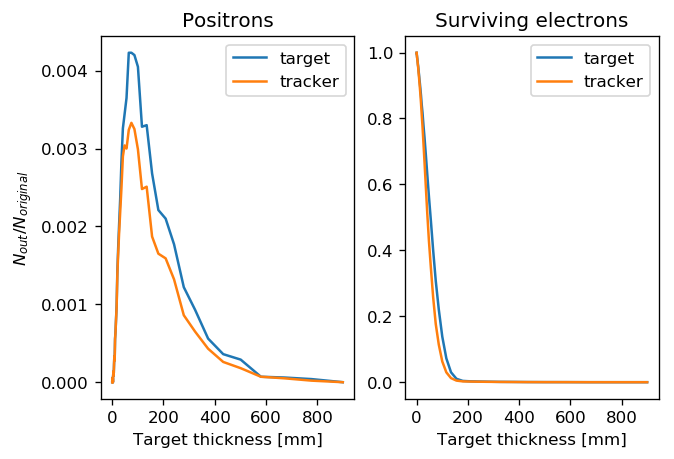

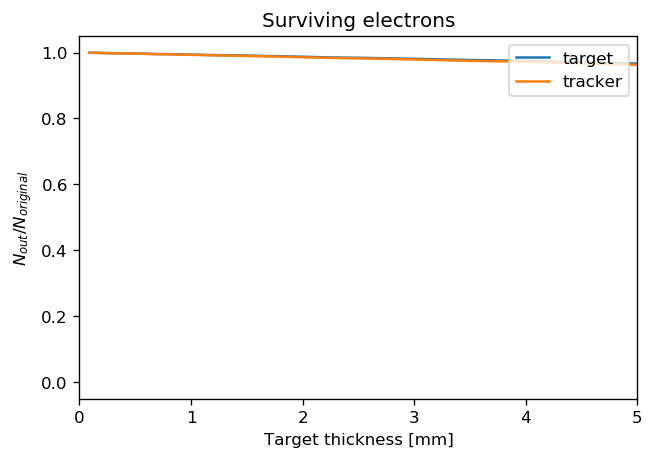

In [12]:
baseSimSetup_Al = baseSimSetup.copy()
baseSimSetup_Al["MAT"] = "G4_Al"
baseSimSetup_Al["DIST"] = 1000.0 #Detector distance from target center [mm] 
thickScan_Al = thickScan_radLen*computeL("Al")

(twiss_Al, numPart_Al, objects_Al, analysis_output_Al) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Al,baseSimSetup_Al, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Al", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_Al,numPart_Al,baseSimSetup_Al["N"])
showYield_singleSim(thickScan_Al,numPart_Al,baseSimSetup_Al["N"], cutoff=True)
showYield_singleSim(thickScan_Al,numPart_Al,baseSimSetup_Al["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')
plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Sapphire.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


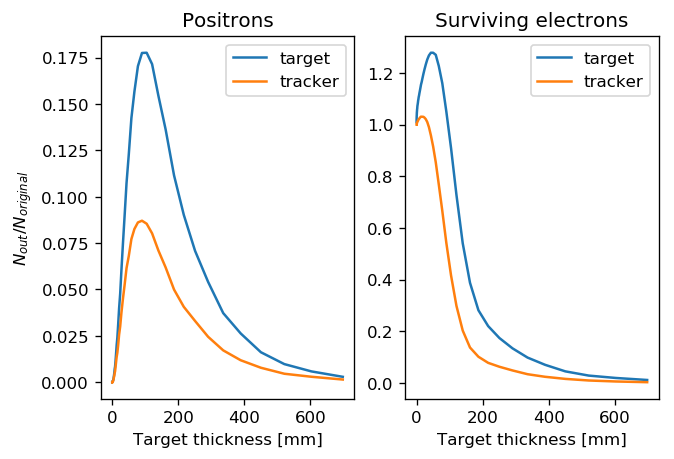

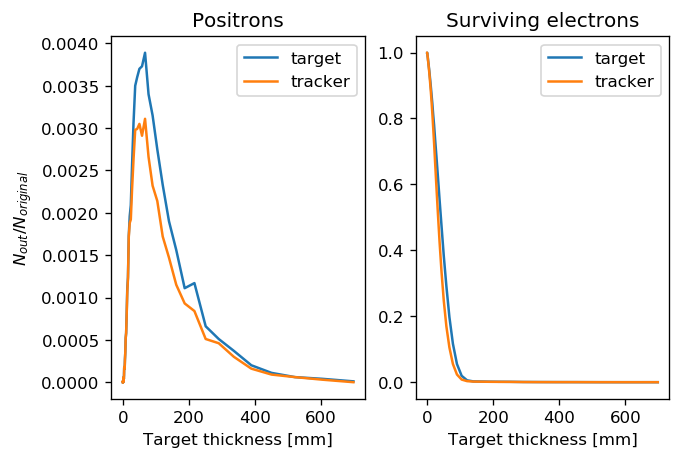

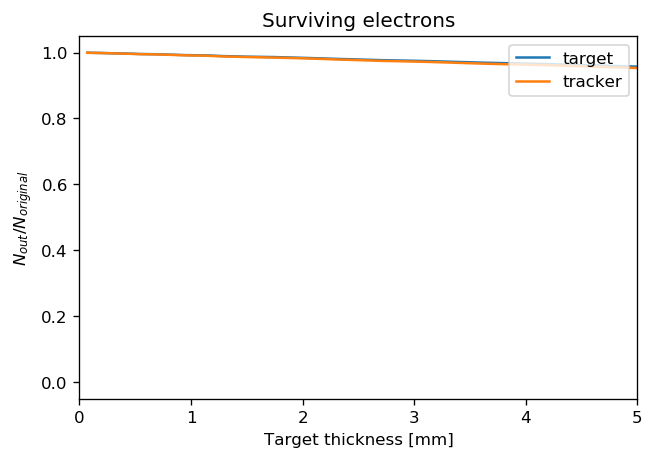

In [13]:
baseSimSetup_Sapphire = baseSimSetup.copy()
baseSimSetup_Sapphire["MAT"] = "Sapphire"
baseSimSetup_Sapphire["DIST"] = 1000.0 #Detector distance from target center [mm] 
thickScan_Sapphire = thickScan_radLen*computeL("Sapphire")

(twiss_Sapphire, numPart_Sapphire, objects_Sapphire, anSapphireysis_output_Sapphire) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Sapphire,baseSimSetup_Sapphire, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Sapphire", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_Sapphire,numPart_Sapphire,baseSimSetup_Sapphire["N"])
showYield_singleSim(thickScan_Sapphire,numPart_Sapphire,baseSimSetup_Sapphire["N"], cutoff=True)
showYield_singleSim(thickScan_Sapphire,numPart_Sapphire,baseSimSetup_Sapphire["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')
plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Pb.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


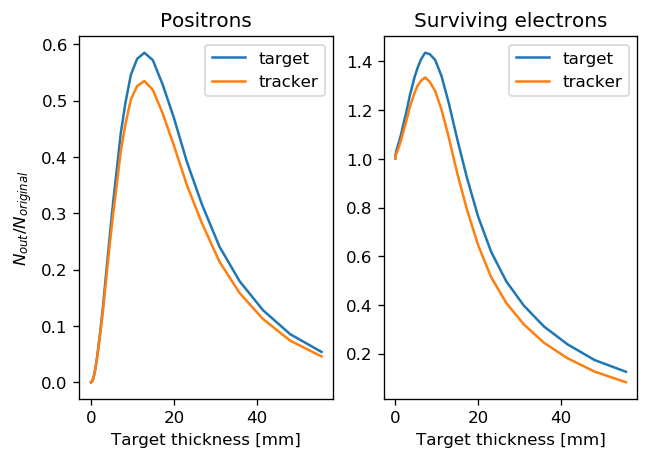

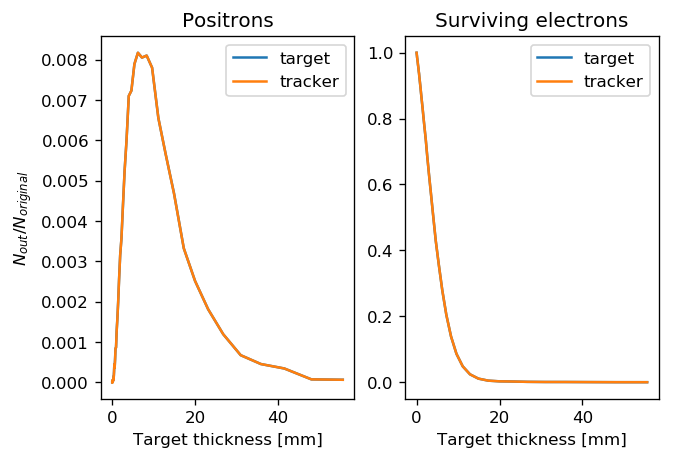

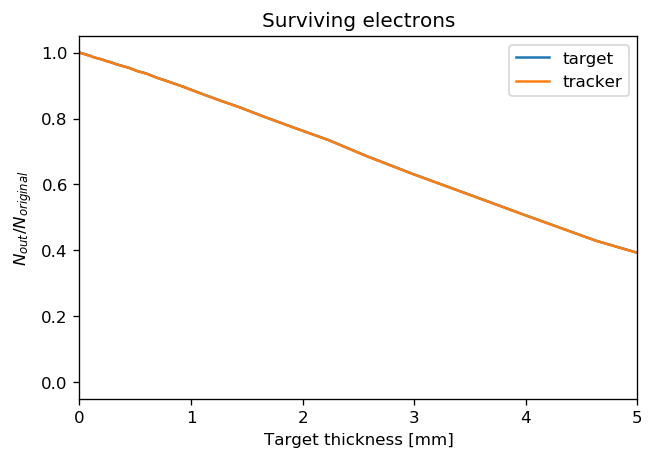

In [14]:
baseSimSetup_Pb = baseSimSetup.copy()
baseSimSetup_Pb["MAT"] = "G4_Pb"
thickScan_Pb = thickScan_radLen*computeL("Pb")

(twiss_Pb, numPart_Pb, objects_Pb, anPbysis_output_Pb) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Pb,baseSimSetup_Pb, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Pb", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_Pb,numPart_Pb,baseSimSetup_Pb["N"])
showYield_singleSim(thickScan_Pb,numPart_Pb,baseSimSetup_Pb["N"], cutoff=True)
showYield_singleSim(thickScan_Pb,numPart_Pb,baseSimSetup_Pb["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')
plt.show()

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Water.h5' True
Loading...
Scan variable ranges match, let's load!
Loaded! That was fast.


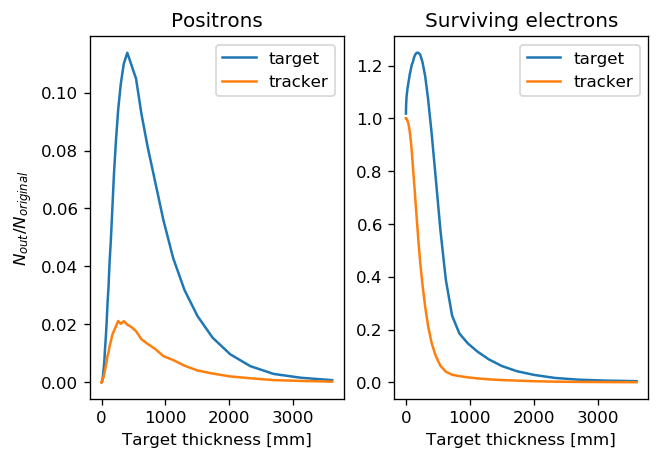

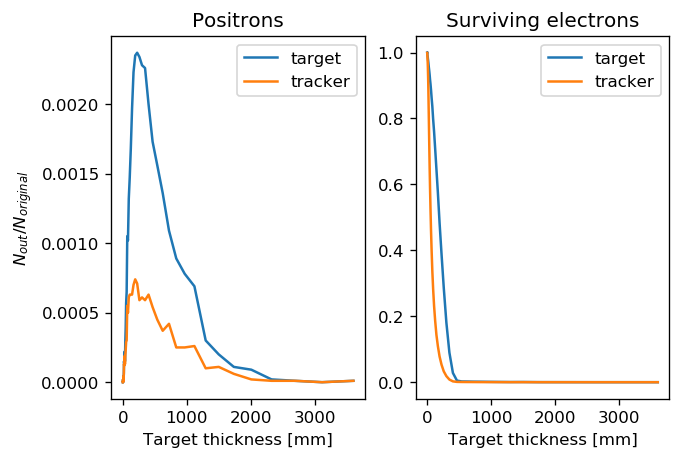

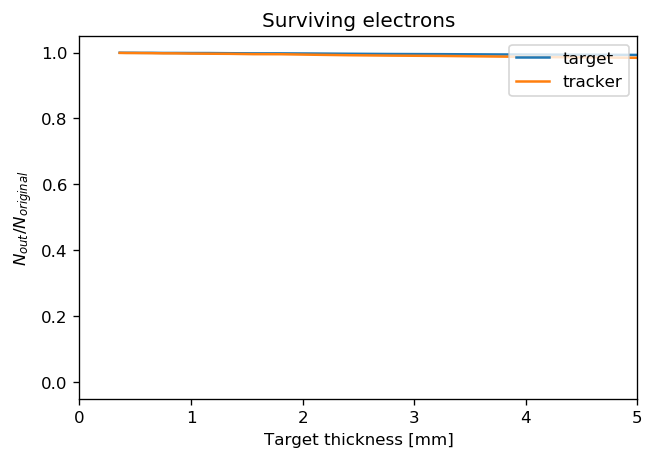

In [15]:
baseSimSetup_Water = baseSimSetup.copy()
baseSimSetup_Water["MAT"] = "G4_WATER"
baseSimSetup_Water["DIST"] = 3000.0 #Detector distance from target center [mm] 
thickScan_Water = thickScan_radLen*computeL("Water")

(twiss_Water, numPart_Water, objects_Water, anPbysis_output_Water) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Water,baseSimSetup_Water, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Water", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

showYield_singleSim(thickScan_Water,numPart_Water,baseSimSetup_Water["N"])
showYield_singleSim(thickScan_Water,numPart_Water,baseSimSetup_Water["N"], cutoff=True)
showYield_singleSim(thickScan_Water,numPart_Water,baseSimSetup_Water["N"], cutoff=True, xZoom=[0.0,5.0], singleParticle='Electrons')
plt.show()

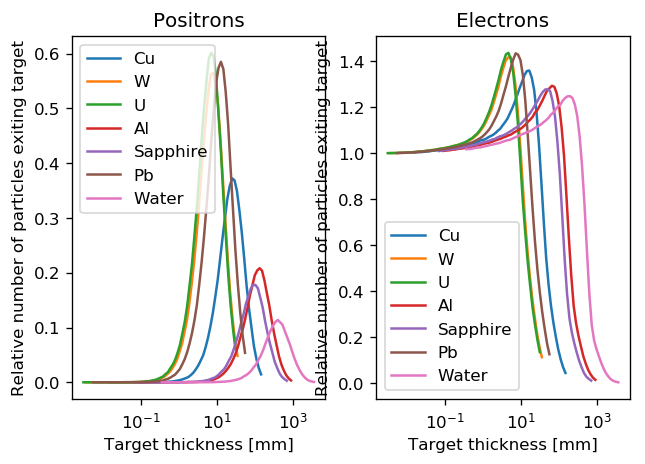

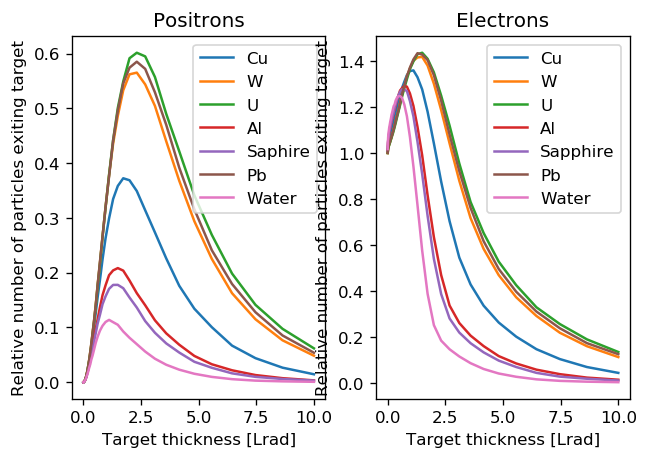

In [16]:
plt.figure()
#plt.clf()

plt.subplot(1,2,1)
plt.title("Positrons")
plt.semilogx(thickScan_Cu,       numPart_Cu["target"][-11]       / baseSimSetup["N"], label="Cu")
plt.semilogx(thickScan_W,        numPart_W["target"][-11]        / baseSimSetup["N"], label="W")
plt.semilogx(thickScan_U,        numPart_U["target"][-11]        / baseSimSetup["N"], label="U")
plt.semilogx(thickScan_Al,       numPart_Al["target"][-11]       / baseSimSetup["N"], label="Al")
plt.semilogx(thickScan_Sapphire, numPart_Sapphire["target"][-11] / baseSimSetup["N"], label="Sapphire")
plt.semilogx(thickScan_Pb,       numPart_Pb["target"][-11]       / baseSimSetup["N"], label="Pb")
plt.semilogx(thickScan_Water,    numPart_Water["target"][-11]    / baseSimSetup["N"], label="Water")

plt.legend()
plt.xlabel("Target thickness [mm]")
plt.ylabel("Relative number of particles exiting target")

plt.subplot(1,2,2)
plt.title("Electrons")

plt.semilogx(thickScan_Cu,       numPart_Cu["target"][11]       / baseSimSetup["N"], label="Cu")
plt.semilogx(thickScan_W,        numPart_W["target"][11]        / baseSimSetup["N"], label="W")
plt.semilogx(thickScan_U,        numPart_U["target"][11]        / baseSimSetup["N"], label="U")
plt.semilogx(thickScan_Al,       numPart_Al["target"][11]       / baseSimSetup["N"], label="Al")
plt.semilogx(thickScan_Sapphire, numPart_Sapphire["target"][11] / baseSimSetup["N"], label="Sapphire")
plt.semilogx(thickScan_Pb,       numPart_Pb["target"][11]       / baseSimSetup["N"], label="Pb")
plt.semilogx(thickScan_Water,    numPart_Water["target"][11]    / baseSimSetup["N"], label="Water")

plt.legend()
plt.xlabel("Target thickness [mm]")
plt.ylabel("Relative number of particles exiting target")

plt.figure()
plt.clf()

plt.subplot(1,2,1)
plt.title("Positrons")

plt.plot(thickScan_radLen,numPart_Cu["target"][-11]       / baseSimSetup["N"], label="Cu")
plt.plot(thickScan_radLen,numPart_W["target"][-11]        / baseSimSetup["N"], label="W")
plt.plot(thickScan_radLen,numPart_U["target"][-11]        / baseSimSetup["N"], label="U")
plt.plot(thickScan_radLen,numPart_Al["target"][-11]       / baseSimSetup["N"], label="Al")
plt.plot(thickScan_radLen,numPart_Sapphire["target"][-11] / baseSimSetup["N"], label="Saphire")
plt.plot(thickScan_radLen,numPart_Pb["target"][-11]       / baseSimSetup["N"], label="Pb")
plt.plot(thickScan_radLen,numPart_Water["target"][-11]    / baseSimSetup["N"], label="Water")

plt.legend()
plt.xlabel("Target thickness [Lrad]")
plt.ylabel("Relative number of particles exiting target")

plt.subplot(1,2,2)
plt.title("Electrons")
plt.plot(thickScan_radLen,numPart_Cu["target"][11]/baseSimSetup["N"], label="Cu")
plt.plot(thickScan_radLen,numPart_W["target"][11]/baseSimSetup["N"],   label="W")
plt.plot(thickScan_radLen,numPart_U["target"][11]/baseSimSetup["N"],   label="U")
plt.plot(thickScan_radLen,numPart_Al["target"][11]/baseSimSetup["N"], label="Al")
plt.plot(thickScan_radLen,numPart_Sapphire["target"][11]/baseSimSetup["N"], label="Sapphire")
plt.plot(thickScan_radLen,numPart_Pb["target"][11]/baseSimSetup["N"], label="Pb")
plt.plot(thickScan_radLen,numPart_Water["target"][11]/baseSimSetup["N"], label="Water")

plt.legend()
plt.xlabel("Target thickness [Lrad]")
plt.ylabel("Relative number of particles exiting target")


plt.show()